In [1]:
!nvidia-smi

Tue Jun 27 03:12:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44091 sha256=702fa7f743e82b3c1176ab39aa49864c4824a67d76cbcb2f84d4dcc2f3a14ffc
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask 2023.6.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
dask-cuda 23.6.0 requires dask==2023.3.2, but you have dask 2023.6.0 which is incompatible.
dask-cudf

<_Logger detectron2 (DEBUG)>

In [3]:
# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
%pwd

'/kaggle/working'

In [5]:
# import torch

# torch.cuda.empty_cache()

In [6]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("snack-data-train", {}, "/kaggle/input/snack-to-50-v2/snack-data-to50/train_100.json", "/kaggle/input/snack-to-50-v2/snack-data-to50/train/resize_img_all")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/snack-to-50-v2/snack-data-to50/val.json", "/kaggle/input/snack-to-50-v2/snack-data-to50/val/resize_val_img_all")

In [7]:
!pwd

/kaggle/working


In [54]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("snack-data-train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1 # 사용할 코어수
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 10  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000 # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 50  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [10]:
trainer = DefaultTrainer(cfg) 

[06/27 03:13:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [11]:
trainer.resume_or_load(resume=False)

[06/27 03:13:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


model_final_f6e8b1.pkl: 243MB [00:01, 167MB/s]                             


In [12]:
trainer.train() # 학습. 겁나김

[06/27 03:14:00 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/27 03:14:40 d2.utils.events]:  eta: 4:19:42  iter: 19  total_loss: 4.773  loss_cls: 3.814  loss_box_reg: 0.9535  loss_rpn_cls: 0.007499  loss_rpn_loc: 0.005767    time: 1.5889  last_time: 1.5455  data_time: 0.4030  last_data_time: 0.3448   lr: 4.9953e-06  max_mem: 9693M


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[06/27 03:15:21 d2.utils.events]:  eta: 4:19:06  iter: 39  total_loss: 4.654  loss_cls: 3.7  loss_box_reg: 0.9642  loss_rpn_cls: 0.008299  loss_rpn_loc: 0.005361    time: 1.6278  last_time: 1.4253  data_time: 0.3777  last_data_time: 0.3608   lr: 9.9902e-06  max_mem: 9693M
[06/27 03:15:53 d2.utils.events]:  eta: 4:18:31  iter: 59  total_loss: 4.408  loss_cls: 3.42  loss_box_reg: 0.9432  loss_rpn_cls: 0.006521  loss_rpn_loc: 0.006    time: 1.6133  last_time: 1.5702  data_time: 0.3936  last_data_time: 0.3648   lr: 1.4985e-05  max_mem: 9693M
[06/27 03:16:24 d2.utils.events]:  eta: 4:18:00  iter: 79  total_loss: 3.895  loss_cls: 2.969  loss_box_reg: 0.9352  loss_rpn_cls: 0.01279  loss_rpn_loc: 0.006305    time: 1.6004  last_time: 1.5572  data_time: 0.3665  last_data_time: 0.3516   lr: 1.998e-05  max_mem: 9694M
[06/27 03:16:56 d2.utils.events]:  eta: 4:17:38  iter: 99  total_loss: 3.251  loss_cls: 2.272  loss_box_reg: 0.9512  loss_rpn_cls: 0.007137  loss_rpn_loc: 0.005696    time: 1.5925  la

In [55]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0009999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/27 08:35:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0009999.pth ...


In [56]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/27 08:35:58 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[06/27 08:35:58 d2.data.datasets.coco]: Loaded 750 images in COCO format from /kaggle/input/snack-to-50-v2/snack-data-to50/val.json
[06/27 08:35:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/27 08:35:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/27 08:35:58 d2.data.common]: Serializing 750 elements to byte tensors and concatenating them all ...
[06/27 08:35:58 d2.data.common]: Serialized dataset takes 0.23 MiB
[06/27 08:35:58 d2.evaluation.evaluator]: Start inference on 750 batches
[06/27 08:35:59 d2.evaluation.evaluator]: Inference done 11/750. Dataloading: 0.0013 s/iter. Inference: 0.0654 s/iter. Eval: 0.0002 s/iter. Total: 0.0669 s/iter. ETA=0:00:49
[06/27 08:36:04 d2.evaluation.evaluator

------------------- 여기까지 평가 ------------------

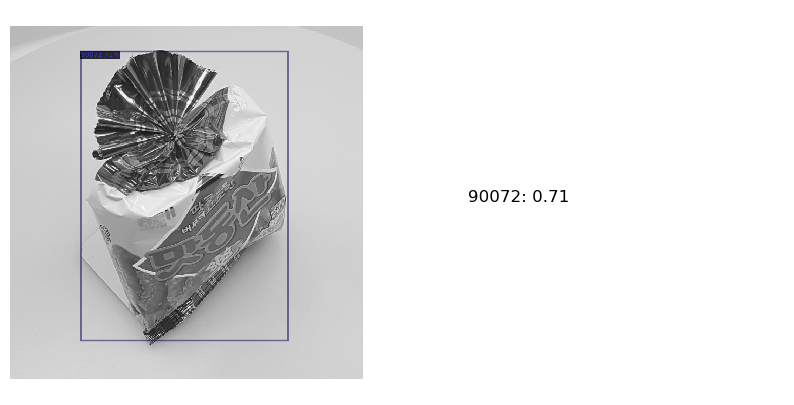

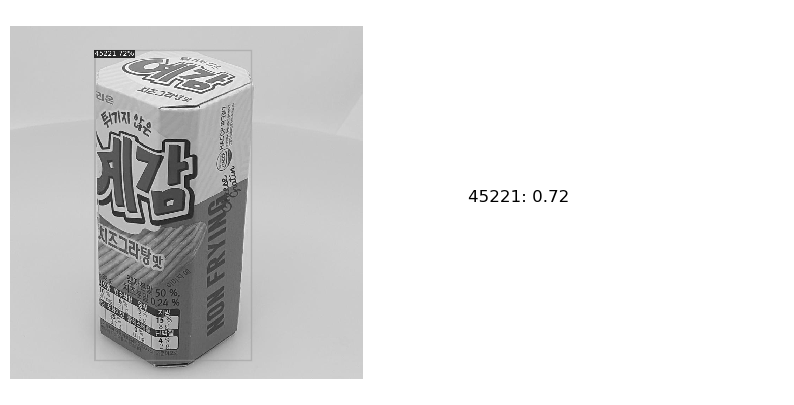

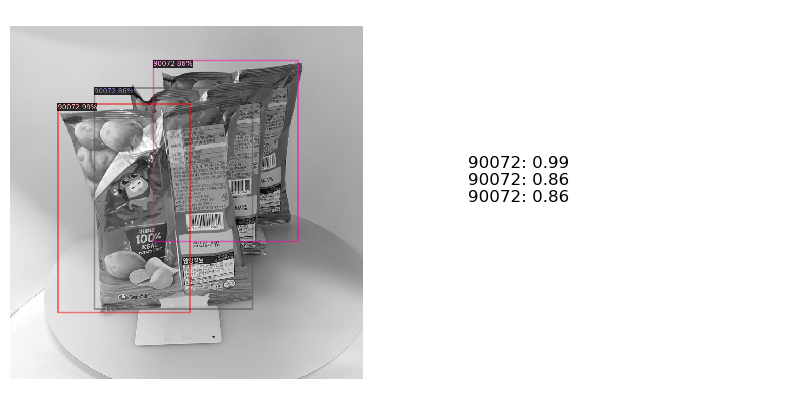

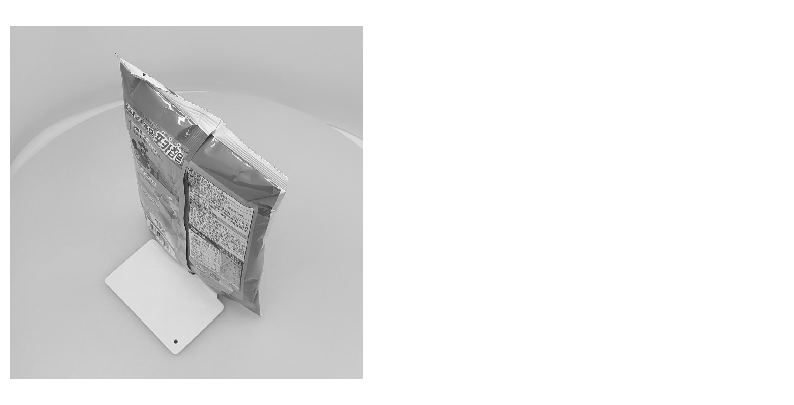

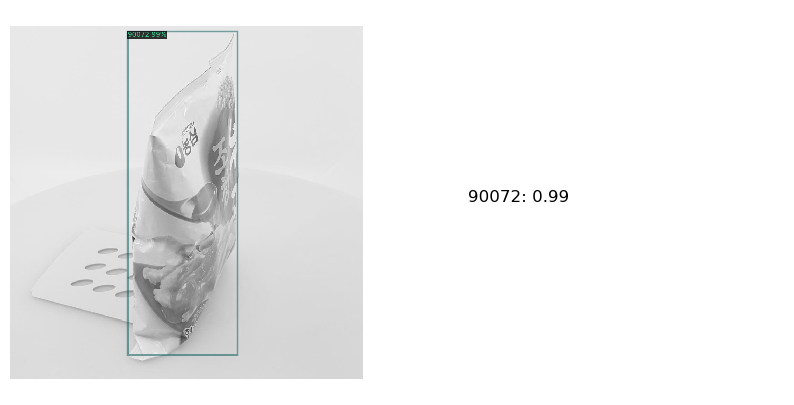

In [61]:
from detectron2.utils.visualizer import ColorMode
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 경로 리스트
image_paths = glob.glob('/kaggle/input/snack-to-50-v2/snack-data-to50/val/resize_val_img_all/*jpg')

# 랜덤하게 5개의 이미지 선택
random_images = random.sample(image_paths, 5)

# 선택된 이미지에 대해 예측 결과 확인
for image_path in random_images:
    im = Image.open(image_path)
    im_np = np.array(im)
    outputs = predictor(im_np)
    v = Visualizer(im_np[:, :, ::-1],
                metadata=test_metadata, 
                scale=.7,  # 이미지 확대
                instance_mode=ColorMode.IMAGE_BW  # 예측 결과만 시각화
                 )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img = out.get_image()[:, :, ::-1]
    
    # 예측 결과 텍스트 출력
    classes = outputs["instances"].pred_classes.to("cpu")
    scores = outputs["instances"].scores.to("cpu")
    labels = [test_metadata.thing_classes[class_id] for class_id in classes]
    predictions = [{"class": label, "score": score} for label, score in zip(labels, scores)]
    text = "\n".join([f"{pred['class']}: {pred['score']:.2f}" for pred in predictions])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, interpolation='nearest')
    ax[0].axis('off')
    ax[1].text(0.1, 0.5, text, fontsize=12)
    ax[1].axis('off')
    plt.show()


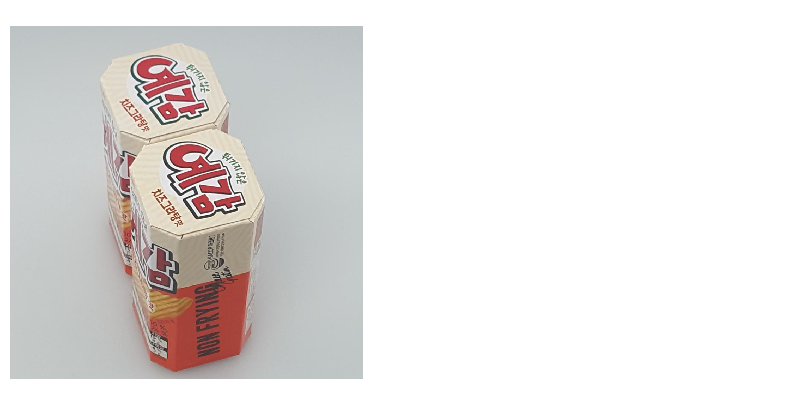

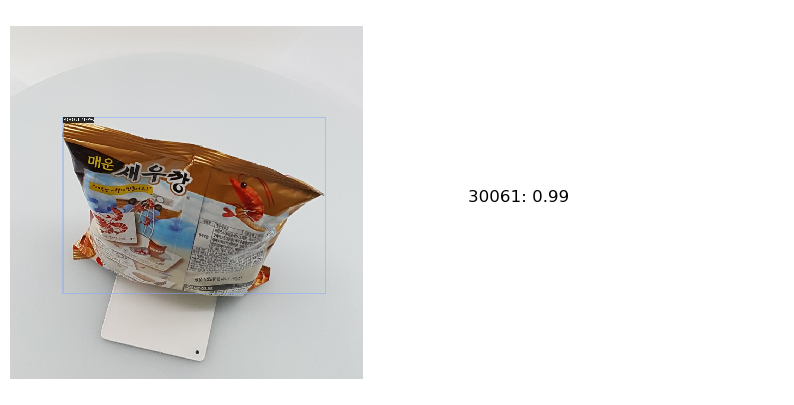

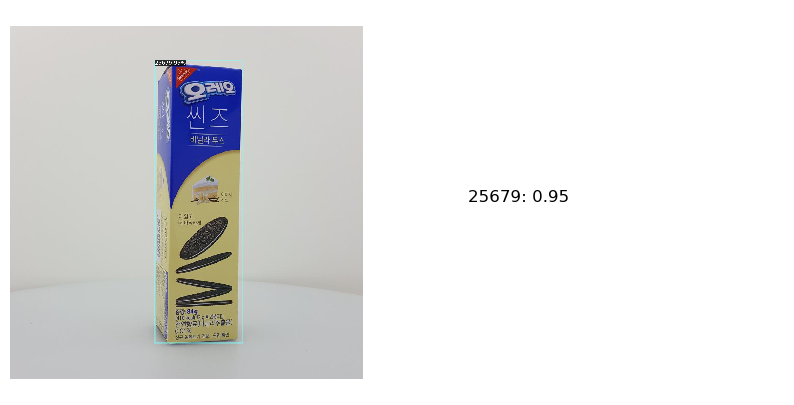

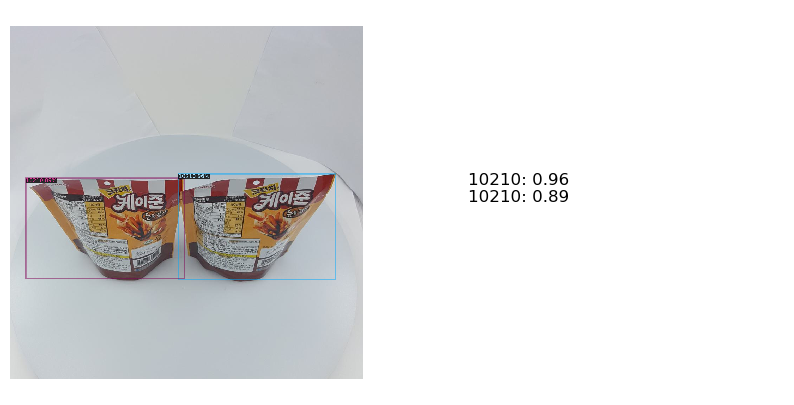

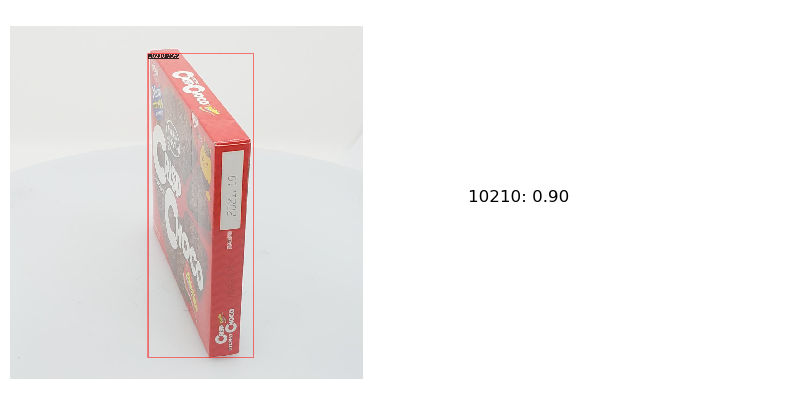

In [62]:
from detectron2.utils.visualizer import ColorMode
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 경로 리스트
image_paths = glob.glob('/kaggle/input/snack-to-50-v2/snack-data-to50/val/resize_val_img_all/*jpg')

# 랜덤하게 5개의 이미지 선택
random_images = random.sample(image_paths, 5)

# 선택된 이미지에 대해 예측 결과 확인
for image_path in random_images:
    im = Image.open(image_path)
    im_np = np.array(im)
    outputs = predictor(im_np)
    v = Visualizer(im_np[:, :, ::-1],
                metadata=test_metadata, 
                scale=2,  # 이미지 확대
                instance_mode=ColorMode.IMAGE  # 예측 결과 컬러로 시각화
                 )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img = out.get_image()[:, :, ::-1]
    
    # 예측 결과 텍스트 출력
    classes = outputs["instances"].pred_classes.to("cpu")
    scores = outputs["instances"].scores.to("cpu")
    labels = [test_metadata.thing_classes[class_id] for class_id in classes]
    predictions = [{"class": label, "score": score} for label, score in zip(labels, scores)]
    text = "\n".join([f"{pred['class']}: {pred['score']:.2f}" for pred in predictions])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, interpolation='nearest')
    ax[0].axis('off')
    ax[1].text(0.1, 0.5, text, fontsize=12)
    ax[1].axis('off')
    plt.show()


#### 

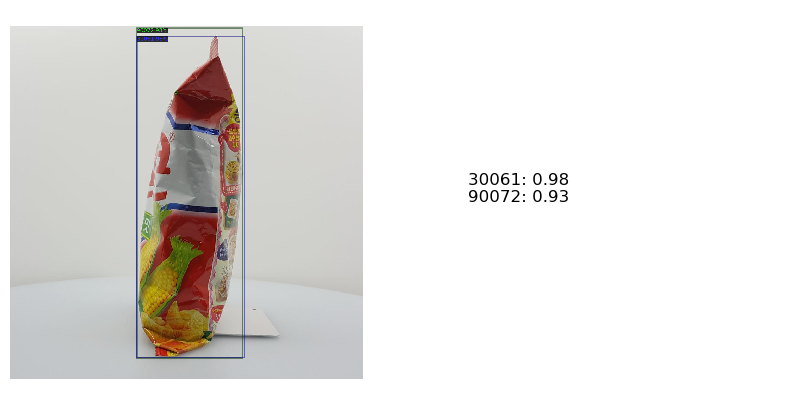

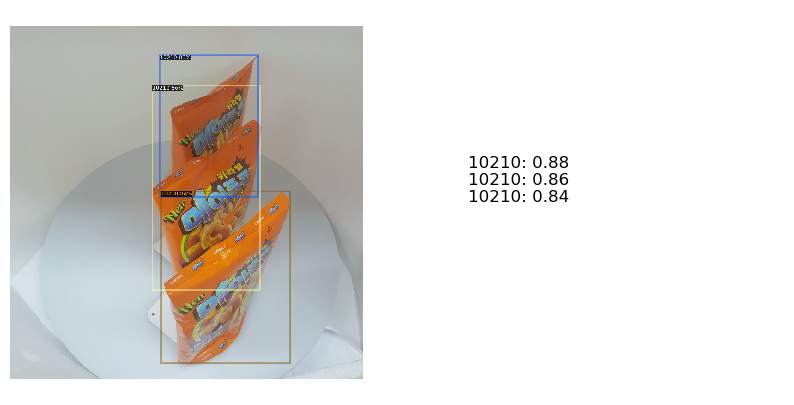

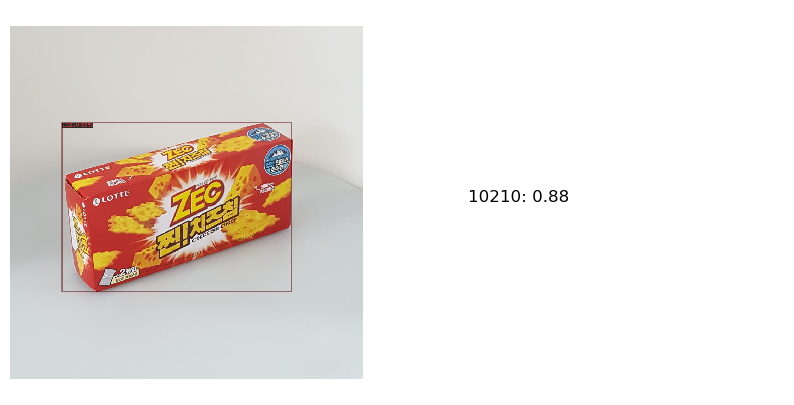

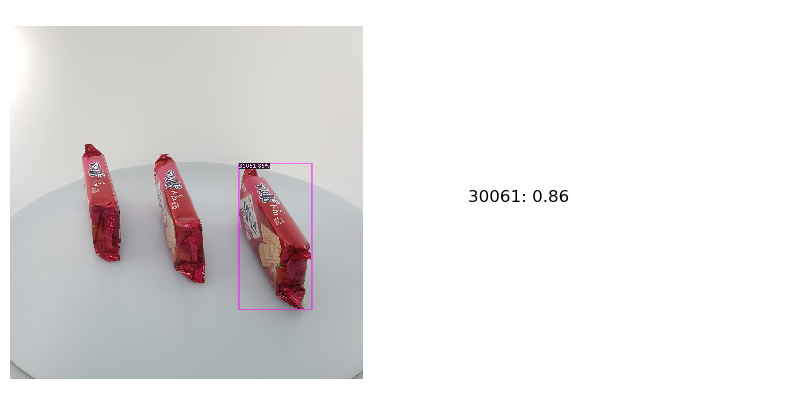

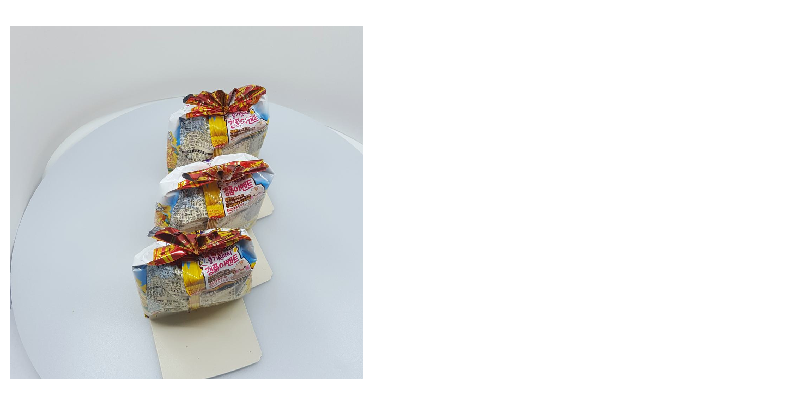

In [63]:
from detectron2.utils.visualizer import ColorMode
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 경로 리스트
image_paths = glob.glob('/kaggle/input/snack-to-50-v2/snack-data-to50/val/resize_val_img_all/*jpg')

# 랜덤하게 5개의 이미지 선택
random_images = random.sample(image_paths, 5)

# 선택된 이미지에 대해 예측 결과 확인
for image_path in random_images:
    im = Image.open(image_path)
    im_np = np.array(im)
    outputs = predictor(im_np)
    v = Visualizer(im_np[:, :, ::-1],
                metadata=test_metadata, 
                scale=2,  # 이미지 확대
                instance_mode=ColorMode.IMAGE  # 예측 결과 컬러로 시각화
                 )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img = out.get_image()[:, :, ::-1]
    
    # 예측 결과 텍스트 출력
    classes = outputs["instances"].pred_classes.to("cpu")
    scores = outputs["instances"].scores.to("cpu")
    labels = [test_metadata.thing_classes[class_id] for class_id in classes]
    predictions = [{"class": label, "score": score} for label, score in zip(labels, scores)]
    text = "\n".join([f"{pred['class']}: {pred['score']:.2f}" for pred in predictions])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, interpolation='nearest')
    ax[0].axis('off')
    ax[1].text(0.1, 0.5, text, fontsize=12)
    ax[1].axis('off')
    plt.show()


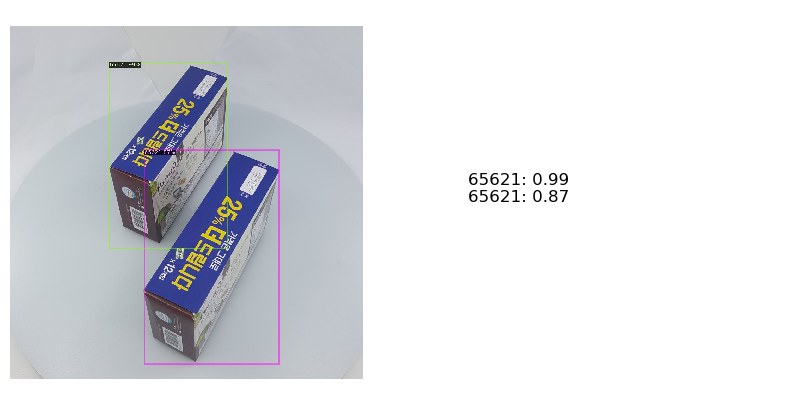

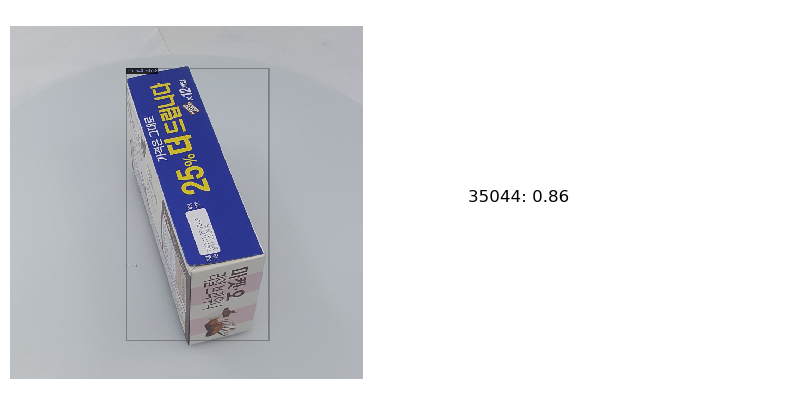

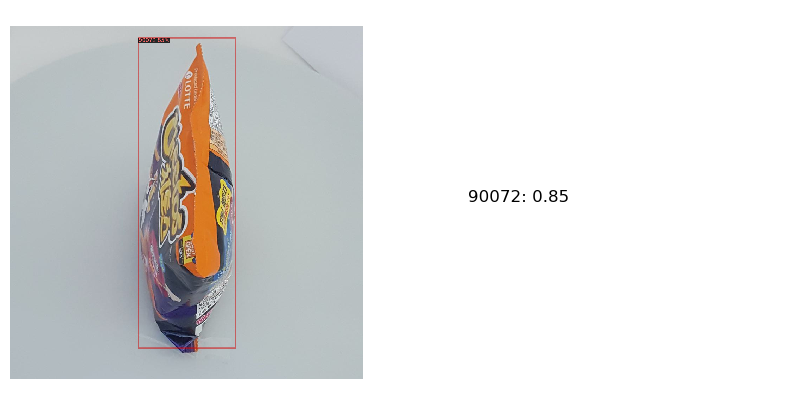

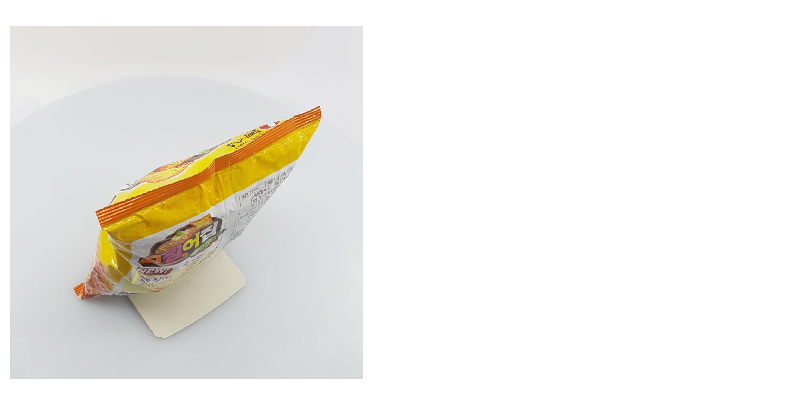

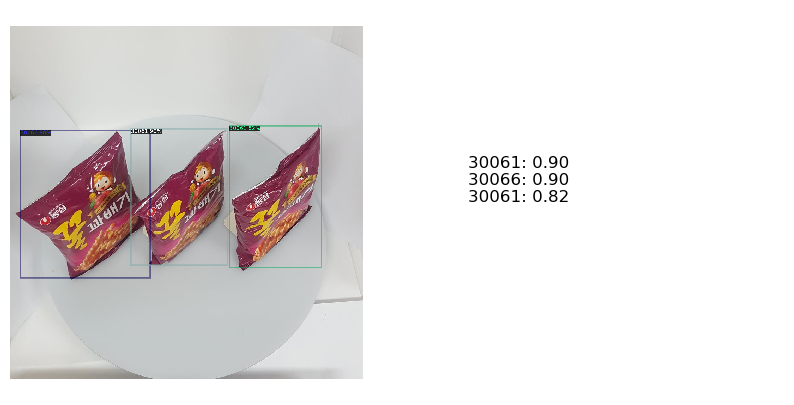

In [64]:
from detectron2.utils.visualizer import ColorMode
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 경로 리스트
image_paths = glob.glob('/kaggle/input/snack-to-50-v2/snack-data-to50/val/resize_val_img_all/*jpg')

# 랜덤하게 5개의 이미지 선택
random_images = random.sample(image_paths, 5)

# 선택된 이미지에 대해 예측 결과 확인
for image_path in random_images:
    im = Image.open(image_path)
    im_np = np.array(im)
    outputs = predictor(im_np)
    v = Visualizer(im_np[:, :, ::-1],
                metadata=test_metadata, 
                scale=2,  # 이미지 확대
                instance_mode=ColorMode.IMAGE  # 예측 결과 컬러로 시각화
                 )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img = out.get_image()[:, :, ::-1]
    
    # 예측 결과 텍스트 출력
    classes = outputs["instances"].pred_classes.to("cpu")
    scores = outputs["instances"].scores.to("cpu")
    labels = [test_metadata.thing_classes[class_id] for class_id in classes]
    predictions = [{"class": label, "score": score} for label, score in zip(labels, scores)]
    text = "\n".join([f"{pred['class']}: {pred['score']:.2f}" for pred in predictions])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, interpolation='nearest')
    ax[0].axis('off')
    ax[1].text(0.1, 0.5, text, fontsize=12)
    ax[1].axis('off')
    plt.show()


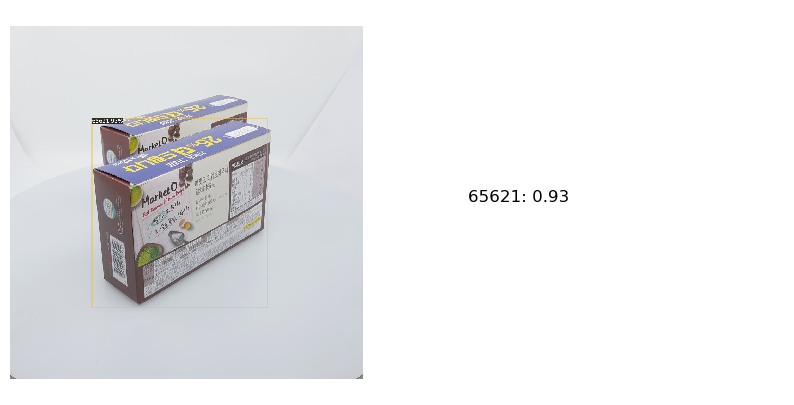

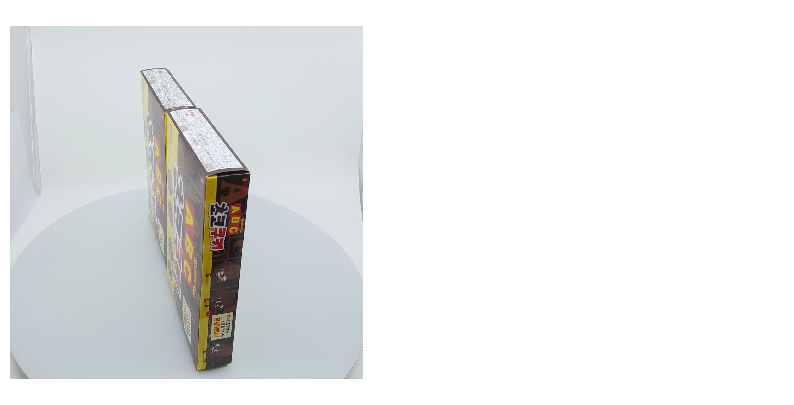

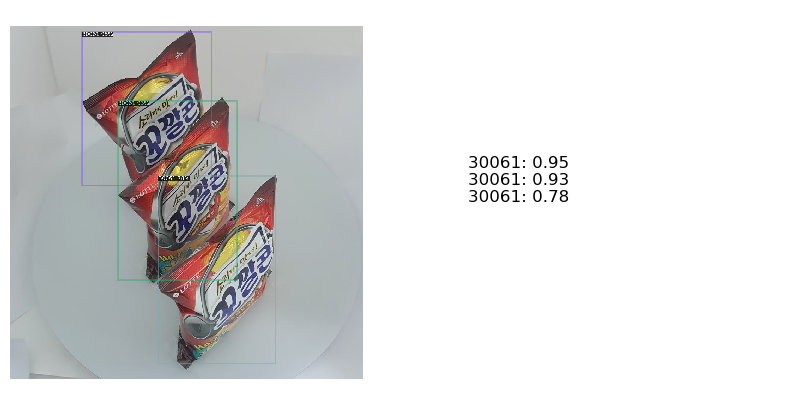

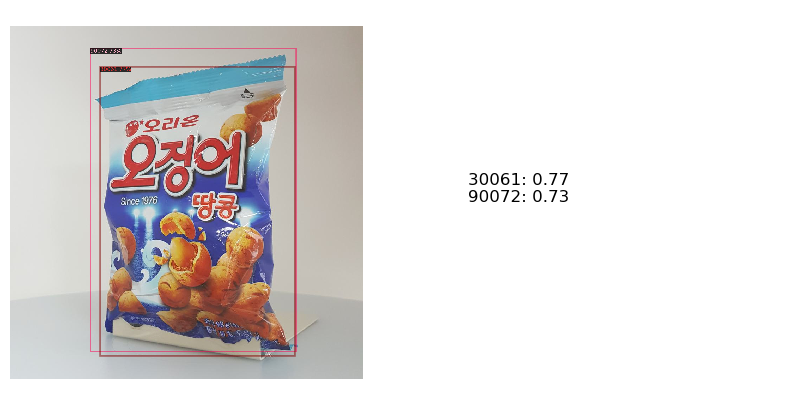

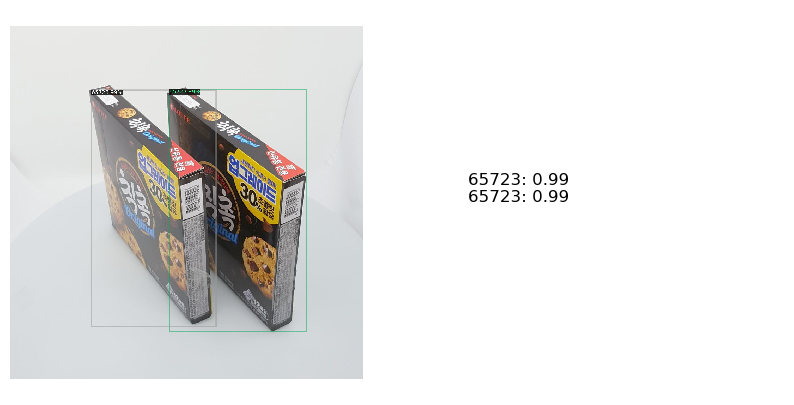

In [65]:
from detectron2.utils.visualizer import ColorMode
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 경로 리스트
image_paths = glob.glob('/kaggle/input/snack-to-50-v2/snack-data-to50/val/resize_val_img_all/*jpg')

# 랜덤하게 5개의 이미지 선택
random_images = random.sample(image_paths, 5)

# 선택된 이미지에 대해 예측 결과 확인
for image_path in random_images:
    im = Image.open(image_path)
    im_np = np.array(im)
    outputs = predictor(im_np)
    v = Visualizer(im_np[:, :, ::-1],
                metadata=test_metadata, 
                scale=2,  # 이미지 확대
                instance_mode=ColorMode.IMAGE  # 예측 결과 컬러로 시각화
                 )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img = out.get_image()[:, :, ::-1]
    
    # 예측 결과 텍스트 출력
    classes = outputs["instances"].pred_classes.to("cpu")
    scores = outputs["instances"].scores.to("cpu")
    labels = [test_metadata.thing_classes[class_id] for class_id in classes]
    predictions = [{"class": label, "score": score} for label, score in zip(labels, scores)]
    text = "\n".join([f"{pred['class']}: {pred['score']:.2f}" for pred in predictions])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, interpolation='nearest')
    ax[0].axis('off')
    ax[1].text(0.1, 0.5, text, fontsize=12)
    ax[1].axis('off')
    plt.show()
